In [1]:
import pandas as pd
import numpy as np
import cooler
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
from matplotlib.patches import Patch
import scipy.io
import warnings

import magic


from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from scipy import stats
import networkx as nx
from sklearn.metrics import jaccard_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

import os
import sys
from importlib import reload

import filters
import pore_c_utils as pcu
import binning_utils as binning
import plotting as hicPlot
import imputation

rocAvA=1.000
rocAvB=0.695
rocAvC=0.658

mannAvA=1.000
mannAvB=0.769
mannAvC=0.605

jacAvA=1.000
jacAvB=0.370
jacAvC=0.298



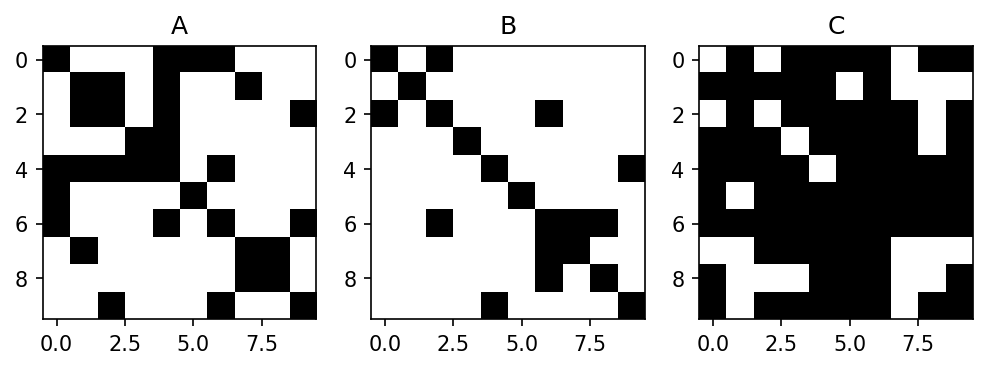

In [2]:
reload(imputation)

# create some random matrices
A = scipy.sparse.random(10, 10, density=0.15)
A = A.todense()
np.fill_diagonal(A, 1)
A = A.T + A
A = np.where(A > 0, 1, 0)

B = scipy.sparse.random(10, 10, density=0.05)
B = B.todense()
B = B.T + B
np.fill_diagonal(B, 1)
B = np.where(B > 0, 1, 0)

C = scipy.sparse.random(10, 10, density=0.45)
C = C.todense()
C = C.T + C
C = np.where(C > 0, 1, 0)


# plot the random matrices

plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = 8, 8

fig = plt.figure()
fig.add_subplot(131)
plt.imshow(A, cmap='binary')
plt.title("A")

fig.add_subplot(132)
plt.imshow(B, cmap='binary')
plt.title("B")

fig.add_subplot(133)
plt.imshow(C, cmap='binary')
plt.title("C")

# compute the AUCROC scores

rocAvA = roc_auc_score(np.triu(A).ravel(), np.triu(A).ravel())
rocAvB = roc_auc_score(np.triu(A).ravel(), np.triu(B).ravel())
rocAvC = roc_auc_score(np.triu(A).ravel(), np.triu(C).ravel())

print(f"{rocAvA=:.3f}")
print(f"{rocAvB=:.3f}")
print(f"{rocAvC=:.3f}")
print()

_, mannAvA = imputation.mannUManual(np.triu(A).ravel(), np.triu(A).ravel())
_, mannAvB = imputation.mannUManual(np.triu(A).ravel(), np.triu(B).ravel())
_, mannAvC = imputation.mannUManual(np.triu(A).ravel(), np.triu(C).ravel())

print(f"{mannAvA=:.3f}")
print(f"{mannAvB=:.3f}")
print(f"{mannAvC=:.3f}")
print()

jacAvA = jaccard_score(np.triu(A).ravel(), np.triu(A).ravel())
jacAvB = jaccard_score(np.triu(A).ravel(), np.triu(B).ravel())
jacAvC = jaccard_score(np.triu(A).ravel(), np.triu(C).ravel())

print(f"{jacAvA=:.3f}")
print(f"{jacAvB=:.3f}")
print(f"{jacAvC=:.3f}")
print()


In [3]:
# break

# Analysis

In [4]:
assembly = pcu.loadAssembly("GRCm39_Assembly.txt")

chromDict = dict(zip(assembly['RefSeq accession'],assembly['Chromosome'].apply(lambda x : f"chr{x}")))

# the reverse for easy lookup
chromDict_r = {v: k for k, v in chromDict.items()}

chromOrder = list(chromDict.values())
chromOrder

['chr1',
 'chr2',
 'chr3',
 'chr4',
 'chr5',
 'chr6',
 'chr7',
 'chr8',
 'chr9',
 'chr10',
 'chr11',
 'chr12',
 'chr13',
 'chr14',
 'chr15',
 'chr16',
 'chr17',
 'chr18',
 'chr19',
 'chrX',
 'chrY']

In [5]:
scHICfilepath = f"/nfs/turbo/umms-indikar/shared/projects/poreC/nagano_2017_data/nagano_1MB_raw_BALANCED.scool"
cellList = list(cooler.fileops.list_coolers(scHICfilepath))
print(f"{len(cellList)=}")

len(cellList)=3882


NOTE: the raw data needs to be re-organized prior to extracting a single chromosome.

In [6]:
sampleSize = 500
chromosome = ['chr2']
sample = np.random.choice(cellList, sampleSize, replace=False)

hic = {}

for i, s in enumerate(sample):
    filetag = "_".join(s.split("_")[0:2]).replace("/", "") + f"_{i}"
    rawMat, hicChromInfo, hicIndex = pcu.loadNagano2017SingleCell(scHICfilepath, s, chromOrder, balance=False)
    
    hicChromInfo = hicChromInfo[hicChromInfo['region'].str.contains('random') == False]
    
    # re-order  the matrix
    hicMat = rawMat[hicIndex, :][:, hicIndex]
    
    # extract the second chromosome
    chrHicInd = pcu.getIndices(hicChromInfo, hicIndex, chromosome, 'region')

    A = hicMat[chrHicInd, :][:, chrHicInd]
   
    # binarize 
    A = np.where(A > 0, 1, 0)
    hic[filetag] = A
#     print(f"{filetag=} {A.shape=}")
    
print('done.')
print(f"{len(hic.keys())=}")

done.
len(hic.keys())=500


In [7]:
for k, v in hic.items():
    assert(v.shape == (182, 182))

(179, 179)


<ipython-input-8-67c11502382b>:23: RuntimeWarning: divide by zero encountered in log
  pltEnsemble = np.where(ensembleTrue > 0, np.log(ensembleTrue), ensembleTrue)


Text(0.5, 1.0, 'Ensemble of 25 Binary Single-Cells')

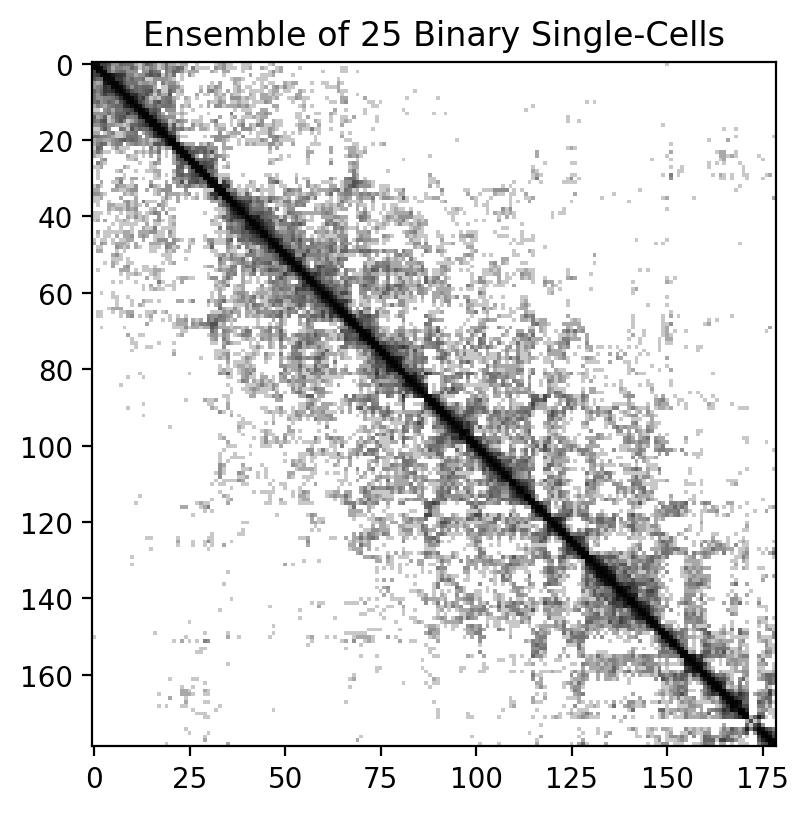

In [8]:
n = 25
sampleKeys = np.random.choice(list(hic.keys()), n)

# generate ensemble data
ensembleTrue = np.zeros((182, 182))

for sampleKey in sampleKeys:
    ensembleTrue += hic[sampleKey]
    
# find indices without contacts
rowsSum = ensembleTrue.sum(axis=0)
rmInd = np.argwhere(rowsSum == 0)

ensembleTrue = np.delete(ensembleTrue, rmInd, axis=0)
ensembleTrue = np.delete(ensembleTrue, rmInd, axis=1)

print(f"{ensembleTrue.shape}")

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 15, 15
fig = plt.figure()

pltEnsemble = np.where(ensembleTrue > 0, np.log(ensembleTrue), ensembleTrue)

fig.add_subplot(131)
plt.imshow(pltEnsemble, cmap='binary')
plt.title(f'Ensemble of {n} Binary Single-Cells')

In [9]:
# remove the missing indices from all matrices

for k, A in hic.items():
    A = np.delete(A, rmInd, axis=0)
    A = np.delete(A, rmInd, axis=1)

#     force diaginal and force adjacent connectionz
#     np.fill_diagonal(A, 1)
#     A = pcu.forceAdjacentConnections(A)
    
    hic[k] = A
    
print('done.')

done.


In [10]:
# break

In [11]:
reload(imputation)

retain = 0.25

uniformMissing = imputation.randomUniformRemoval(hic, retain=retain)
print(f"{len(uniformMissing.keys())=}")

degreeLimit = imputation.degreeLimitRemoval(hic, retain=retain)
print(f"{len(degreeLimit.keys())=}")

crawlMissing = imputation.breadthFirstRemoval(hic, retain=retain)
print(f"{len(crawlMissing.keys())=}")

coldEnd = imputation.coldEndRemoval(hic, retain=retain)
print(f"{len(coldEnd.keys())=}")

print('done.')

len(uniformMissing.keys())=500
len(degreeLimit.keys())=500
len(crawlMissing.keys())=500
len(coldEnd.keys())=500
done.


In [12]:
# break

sampleKey='Diploid_9_297'


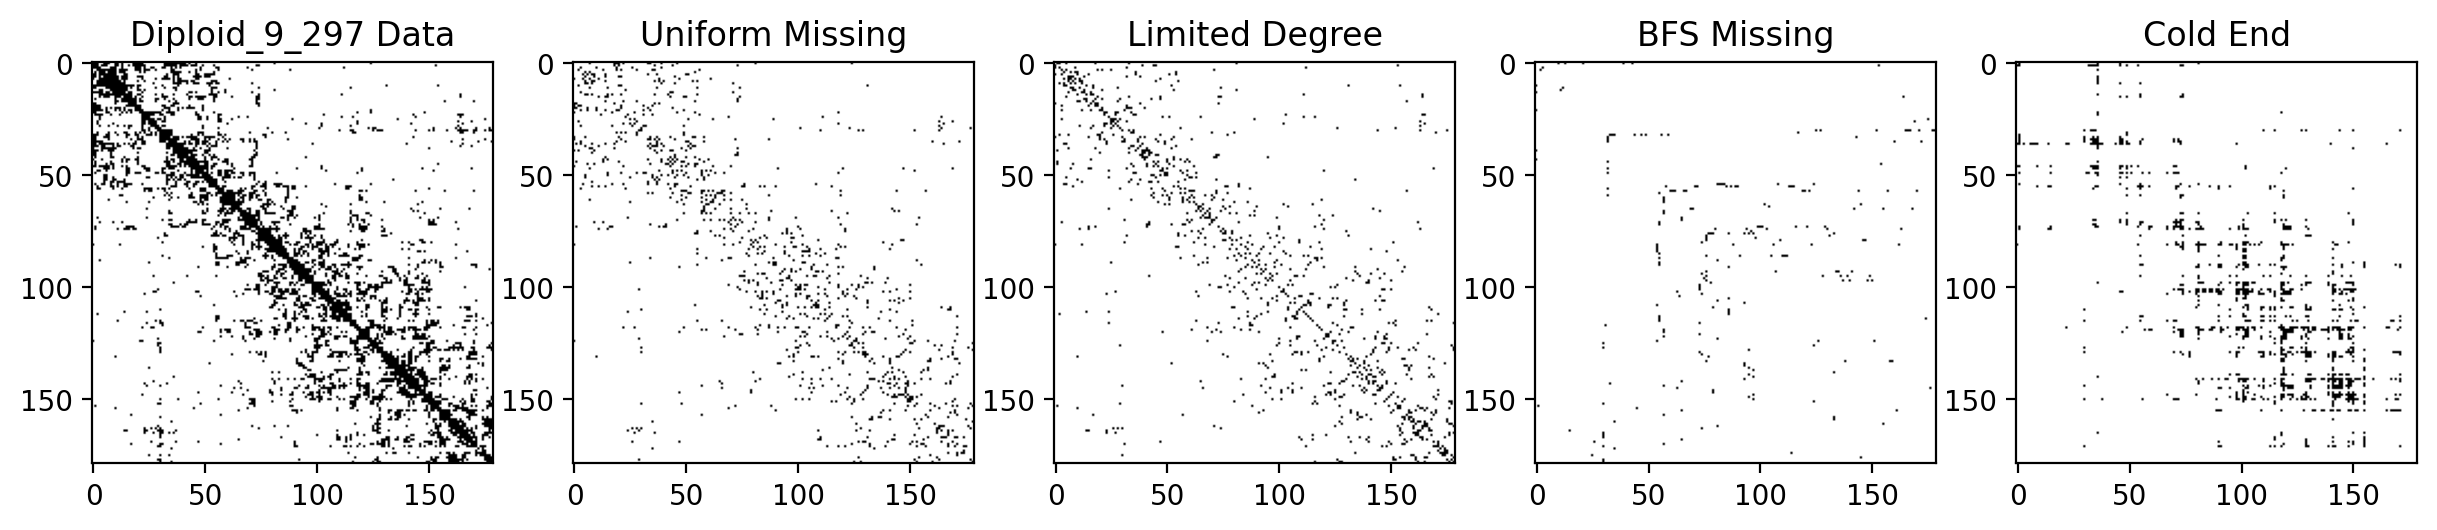

sampleKey='Diploid_12_59'


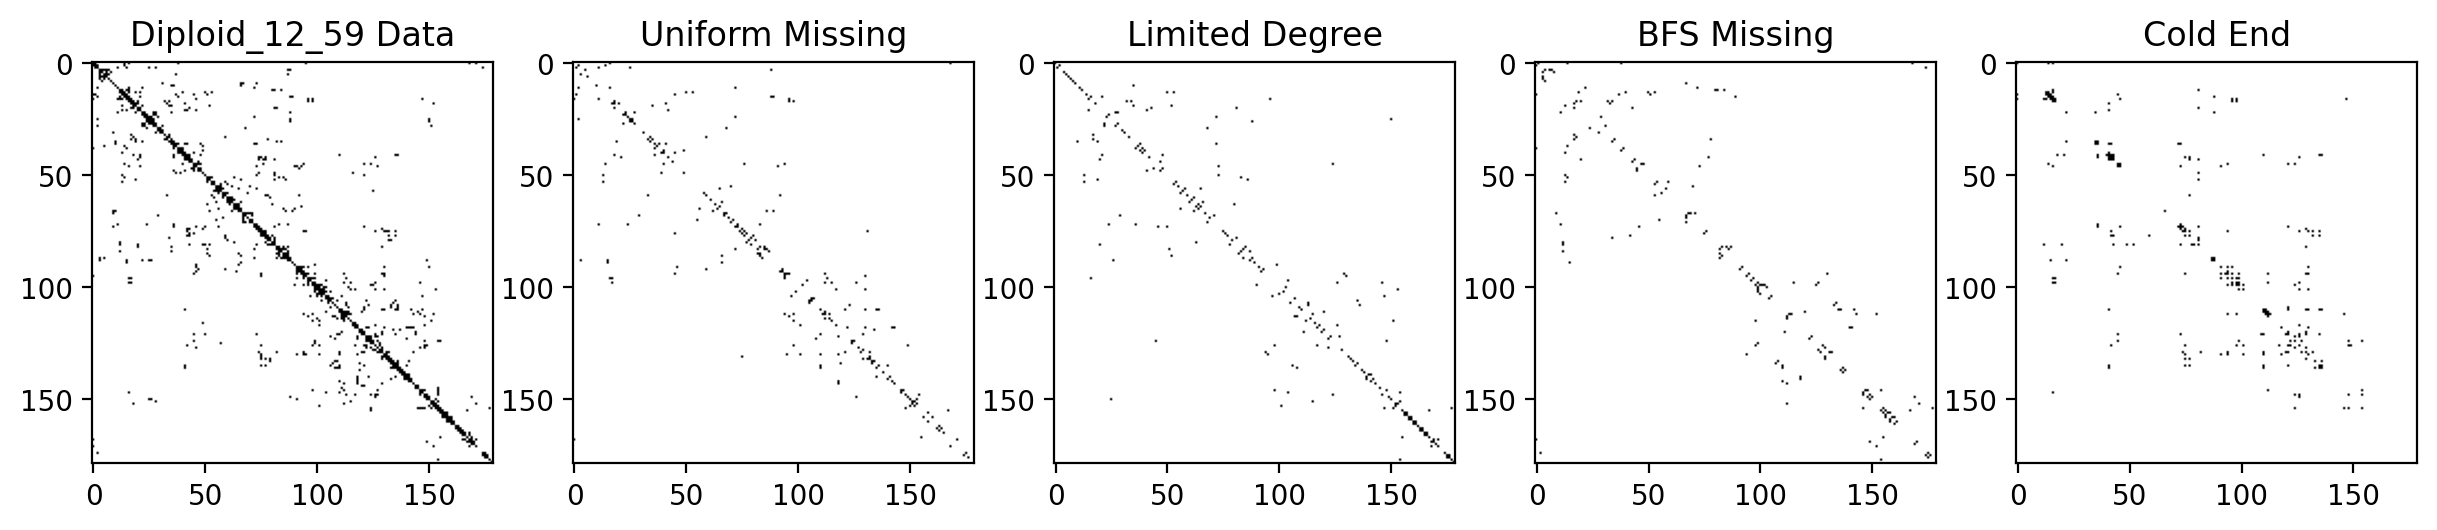

In [13]:
n = 2
sampleKeys = np.random.choice(list(coldEnd.keys()), n, replace=False)

for sampleKey in sampleKeys:

    print(f"{sampleKey=}")

    plt.rcParams['figure.dpi'] = 200
    plt.rcParams['figure.figsize'] = 15, 15
    fig = plt.figure()

    fig.add_subplot(151)
    plt.imshow(hic[sampleKey], cmap='binary')
    plt.title(f'{sampleKey} Data')

    fig.add_subplot(152)
    plt.imshow(uniformMissing[sampleKey], cmap='binary')
    plt.title('Uniform Missing')

    fig.add_subplot(153)
    plt.imshow(degreeLimit[sampleKey], cmap='binary')
    plt.title('Limited Degree')

    fig.add_subplot(154)
    plt.imshow(crawlMissing[sampleKey], cmap='binary')
    plt.title('BFS Missing')

    fig.add_subplot(155)
    plt.imshow(coldEnd[sampleKey], cmap='binary')
    plt.title('Cold End')
    
    plt.show()

In [14]:
def computeYoudin(true, scores):
    """A function to compute the optimal threshold"""
    fpr, tpr, thresholds = roc_curve(true, scores)
    j_scores = tpr - fpr
    j_ordered = sorted(zip(j_scores, thresholds))
    return j_ordered[-1][1]

In [15]:
tau = 0.5

missingType = {
#     'Random Uniform' : uniformMissing,
    'Degree Limited' : degreeLimit,
    'Crawl Limited' : crawlMissing,
    'Cold-end Limited' : coldEnd
}

predictionAlgo = {
#     'Resource Allocation' : lambda x : imputation.imputeEdges(x, tau, method=1),
    'Preferential Attachment' : lambda x : imputation.imputeEdges(x, tau, method=2),
    'Adamic-Adar' : lambda x : imputation.imputeEdges(x, tau, method=3),
    'CCPA' : lambda x : imputation.imputeEdges(x, tau, method=4),
}

newRows = []

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    for algoName, algoFunc in predictionAlgo.items():
        print(f"{algoName=}")
        for mTypeName, Adict in missingType.items():
            print(f"\t{mTypeName=}")
            for key in hic.keys():

                Atrain = Adict[key]
                Atrue = hic[key]
                Apred, Ascores = algoFunc(Atrain)

                # AUC computed with scores
                try:
                    AUC = roc_auc_score(np.triu(Atrue).ravel(), 
                                        np.triu(Ascores).ravel())
                except ValueError:
                    AUC = 0.5

                _, mannU = imputation.mannUManual(np.triu(Atrue).ravel(), 
                                                  np.triu(Apred).ravel())

                Youdin = computeYoudin(np.triu(Atrue).ravel(), 
                                        np.triu(Ascores).ravel())
                
                Jaccard = jaccard_score(np.triu(Atrue).ravel(), 
                                        np.triu(Apred).ravel(), 
                                        zero_division='ignore')

                Fnorm = np.linalg.norm(Atrue - Apred)

                nTrue = np.sum(np.sum(Atrue))
                nPred = np.sum(np.sum(Apred))

                tn, fp, fn, tp = confusion_matrix(np.triu(Atrue).ravel(), np.triu(Apred).ravel(), labels=[0, 1]).ravel()

                row = {
                    'cell' : key,
                    'predictionAlgorithm' : algoName,
                    'missingType' : mTypeName,
                    'Jaccard_Index' : Jaccard,
                    'Fnorm' : Fnorm,
                    'AUCROC' : AUC,
                    'MannUAUC' : mannU,
                    'nTrue' : nTrue,
                    'nPred' : nPred,
                    'TrueNegative' : tn,
                    'TruePositive' : tp,
                    'FalseNegative' : fn,
                    'FalsePositive' : fp,
                    'sensitivity' : tp / (tp + fn),
                    'specificity' : tn / (tn + fp),
                    'precision' : tp / (tp + fp),
                    'falseDiscovery' : fp / (fp + tp),
                    'Youdin' : Youdin,
                    'Apred' : Apred,
                    'Atrue' : Atrue,
                    'Atrain' : Atrain,
                    'Ascores' : Ascores,
                }
                newRows.append(row)

df = pd.DataFrame(newRows)
print(f"{df.shape=}")
df.head()

algoName='Preferential Attachment'
	mTypeName='Degree Limited'
	mTypeName='Crawl Limited'
	mTypeName='Cold-end Limited'
algoName='Adamic-Adar'
	mTypeName='Degree Limited'
	mTypeName='Crawl Limited'
	mTypeName='Cold-end Limited'
algoName='CCPA'
	mTypeName='Degree Limited'
	mTypeName='Crawl Limited'
	mTypeName='Cold-end Limited'
df.shape=(4500, 22)


,cell,predictionAlgorithm,missingType,Jaccard_Index,Fnorm,AUCROC,MannUAUC,nTrue,nPred,TrueNegative,...,FalsePositive,sensitivity,specificity,precision,falseDiscovery,Youdin,Apred,Atrue,Atrain,Ascores
0,Diploid_19_0,Preferential Attachment,Degree Limited,0.061807,128.378347,0.580148,0.672126,1761,16740,23207,...,7865,0.563467,0.746878,0.064915,0.935085,0.250000,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",[[[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0....,"[[0.0, 0.1875, 0.1875, 0.1875, 0.125, 0.1875, ..."
1,Diploid_31_1,Preferential Attachment,Degree Limited,0.051607,112.969022,0.559711,0.682734,1318,12692,25259,...,6034,0.467914,0.807177,0.054825,0.945175,0.111111,"[[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,...","[[1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,...",[[[[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0....,"[[0.0, 0.4444444444444444, 0.2222222222222222,..."
2,Diploid_31_2,Preferential Attachment,Degree Limited,0.051982,146.331815,0.571299,0.698179,1573,22060,20691,...,10475,0.674286,0.663897,0.053321,0.946679,0.111111,"[[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,...",[[[[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0....,"[[0.0, 0.2222222222222222, 0.2222222222222222,..."
3,Diploid_19_3,Preferential Attachment,Degree Limited,0.022394,49.859803,0.501481,0.684330,152,2450,30746,...,1196,0.292929,0.962557,0.023673,0.976327,1.000000,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",[[[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0....,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,Diploid_21_4,Preferential Attachment,Degree Limited,0.025936,84.634508,0.473052,0.639823,419,7056,28301,...,3450,0.334483,0.891342,0.027347,0.972653,2.000000,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,...","[[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,...",[[[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1....,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


# MAGIC Imputation

In [16]:
res = {}

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    for mTypeName, Adict in missingType.items():

        multiCellTrain = []
        multiCellTrue = []
        keys = []


        for key in hic.keys():
            Atrain = np.asarray(Adict[key])
            Atrue = np.asarray(hic[key])

            multiCellTrain.append(Atrain.flatten())
            multiCellTrue.append(Atrue.flatten())
            
            keys.append(key)

        multiCellTrain = np.asarray(multiCellTrain)
        multiCellTrue = np.asarray(multiCellTrue)

        print(f"{multiCellTrain.shape=}")
        print(f"{multiCellTrue.shape=}")

        magic_operator = magic.MAGIC(verbose=False,
                                     knn=7,
                                     t=2, 
                                     n_pca=4)


        multiCellScores = magic_operator.fit_transform(multiCellTrain)
        print(f"{multiCellScores.shape=}")
        
        res[mTypeName] = {
            'True' : multiCellTrue,
            'Train' : multiCellTrain,
            'Scores' : multiCellScores,
            'cellKeys' : keys
        }

res.keys()

multiCellTrain.shape=(500, 32041)
multiCellTrue.shape=(500, 32041)
  Running MAGIC with `solver='exact'` on 32041-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
multiCellScores.shape=(500, 32041)
multiCellTrain.shape=(500, 32041)
multiCellTrue.shape=(500, 32041)
  Running MAGIC with `solver='exact'` on 32041-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
multiCellScores.shape=(500, 32041)
multiCellTrain.shape=(500, 32041)
multiCellTrue.shape=(500, 32041)
  Running MAGIC with `solver='exact'` on 32041-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
multiCellScores.shape=(500, 32041)


dict_keys(['Degree Limited', 'Crawl Limited', 'Cold-end Limited'])

In [17]:
tau = 0.15

newRows = []

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    for mTypeName, data in res.items():

        for key in hic.keys():
            idx = data['cellKeys'].index(key)

            Atrue = data['True'][idx, :]
            Atrain = data['Train'][idx, :]
            Ascores = data['Scores'][idx, :]

            dim = int(np.sqrt(Atrue.shape[0]))

            Atrue = Atrue.reshape((dim, dim))
            Atrain = Atrain.reshape((dim, dim))
            Ascores = Ascores.reshape((dim, dim))


             # AUC computed with scores
            try:
                AUC = roc_auc_score(np.triu(Atrue).ravel(), 
                                    np.triu(Ascores).ravel())
            except ValueError:
                AUC = 0.5

            Youdin = computeYoudin(np.triu(Atrue).ravel(), 
                                    np.triu(Ascores).ravel())
                
            Apred = np.where(Ascores > tau, 1, 0)
            

            _, mannU = imputation.mannUManual(np.triu(Atrue).ravel(), 
                                              np.triu(Apred).ravel())

            Jaccard = jaccard_score(np.triu(Atrue).ravel(), 
                                    np.triu(Apred).ravel(), 
                                    zero_division='ignore')

            Fnorm = np.linalg.norm(Atrue - Apred)

            nTrue = np.sum(np.sum(Atrue))
            nPred = np.sum(np.sum(Apred))

            tn, fp, fn, tp = confusion_matrix(np.triu(Atrue).ravel(), np.triu(Apred).ravel(), labels=[0, 1]).ravel()

            row = {
                'cell' : key,
                'predictionAlgorithm' : 'MAGIC',
                'missingType' : mTypeName,
                'Jaccard_Index' : Jaccard,
                'Fnorm' : Fnorm,
                'AUCROC' : AUC,
                'MannUAUC' : mannU,
                'nTrue' : nTrue,
                'nPred' : nPred,
                'TrueNegative' : tn,
                'TruePositive' : tp,
                'FalseNegative' : fn,
                'FalsePositive' : fp,
                'sensitivity' : tp / (tp + fn),
                'specificity' : tn / (tn + fp),
                'precision' : tp / (tp + fp),
                'falseDiscovery' : fp / (fp + tp),
                'Youdin' : Youdin,
                'Apred' : Apred,
                'Atrue' : Atrue,
                'Atrain' : Atrain,
                'Ascores' : Ascores
            }

            newRows.append(row)

dfMagic = pd.DataFrame(newRows)
print(f"{dfMagic.shape=}")
dfMagic.head()

dfMagic.shape=(1500, 22)


,cell,predictionAlgorithm,missingType,Jaccard_Index,Fnorm,AUCROC,MannUAUC,nTrue,nPred,TrueNegative,...,FalsePositive,sensitivity,specificity,precision,falseDiscovery,Youdin,Apred,Atrue,Atrain,Ascores
0,Diploid_19_0,MAGIC,Degree Limited,0.330303,36.400549,0.868598,0.678415,1761,518,31051,...,21,0.337461,0.999324,0.939655,0.060345,0.002477,"[[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.56544846509966, 0.20881969040141385, 0.076..."
1,Diploid_31_1,MAGIC,Degree Limited,0.412385,29.832868,0.912796,0.725374,1318,470,31282,...,11,0.418449,0.999648,0.966049,0.033951,0.000225,"[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.4804031673356574, 0.06837663068171944, 0.0..."
2,Diploid_31_2,MAGIC,Degree Limited,0.378227,33.271610,0.920986,0.709084,1573,528,31150,...,16,0.385143,0.999487,0.954674,0.045326,0.001405,"[[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0,...","[[0.48380506253935507, 0.15305012191723666, 0...."
3,Diploid_19_3,MAGIC,Degree Limited,0.043860,12.727922,0.720929,0.565715,152,20,31927,...,15,0.050505,0.999530,0.250000,0.750000,0.000462,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.03598748161618455, 0.0, 0.0, 0.0, 0.0..."
4,Diploid_21_4,MAGIC,Degree Limited,0.282828,18.493242,0.828924,0.723300,419,97,31744,...,7,0.289655,0.999780,0.923077,0.076923,0.000238,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.10687601184393984, 0.0019673891830999..."


In [18]:
# combine the two sets of evaluation data

results = pd.concat([df, dfMagic], ignore_index=True)
print(f"{results.shape=}")
results.head()

results.shape=(6000, 22)


,cell,predictionAlgorithm,missingType,Jaccard_Index,Fnorm,AUCROC,MannUAUC,nTrue,nPred,TrueNegative,...,FalsePositive,sensitivity,specificity,precision,falseDiscovery,Youdin,Apred,Atrue,Atrain,Ascores
0,Diploid_19_0,Preferential Attachment,Degree Limited,0.061807,128.378347,0.580148,0.672126,1761,16740,23207,...,7865,0.563467,0.746878,0.064915,0.935085,0.250000,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",[[[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0....,"[[0.0, 0.1875, 0.1875, 0.1875, 0.125, 0.1875, ..."
1,Diploid_31_1,Preferential Attachment,Degree Limited,0.051607,112.969022,0.559711,0.682734,1318,12692,25259,...,6034,0.467914,0.807177,0.054825,0.945175,0.111111,"[[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,...","[[1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,...",[[[[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0....,"[[0.0, 0.4444444444444444, 0.2222222222222222,..."
2,Diploid_31_2,Preferential Attachment,Degree Limited,0.051982,146.331815,0.571299,0.698179,1573,22060,20691,...,10475,0.674286,0.663897,0.053321,0.946679,0.111111,"[[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,...",[[[[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0....,"[[0.0, 0.2222222222222222, 0.2222222222222222,..."
3,Diploid_19_3,Preferential Attachment,Degree Limited,0.022394,49.859803,0.501481,0.684330,152,2450,30746,...,1196,0.292929,0.962557,0.023673,0.976327,1.000000,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",[[[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0....,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,Diploid_21_4,Preferential Attachment,Degree Limited,0.025936,84.634508,0.473052,0.639823,419,7056,28301,...,3450,0.334483,0.891342,0.027347,0.972653,2.000000,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,...","[[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,...",[[[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1....,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


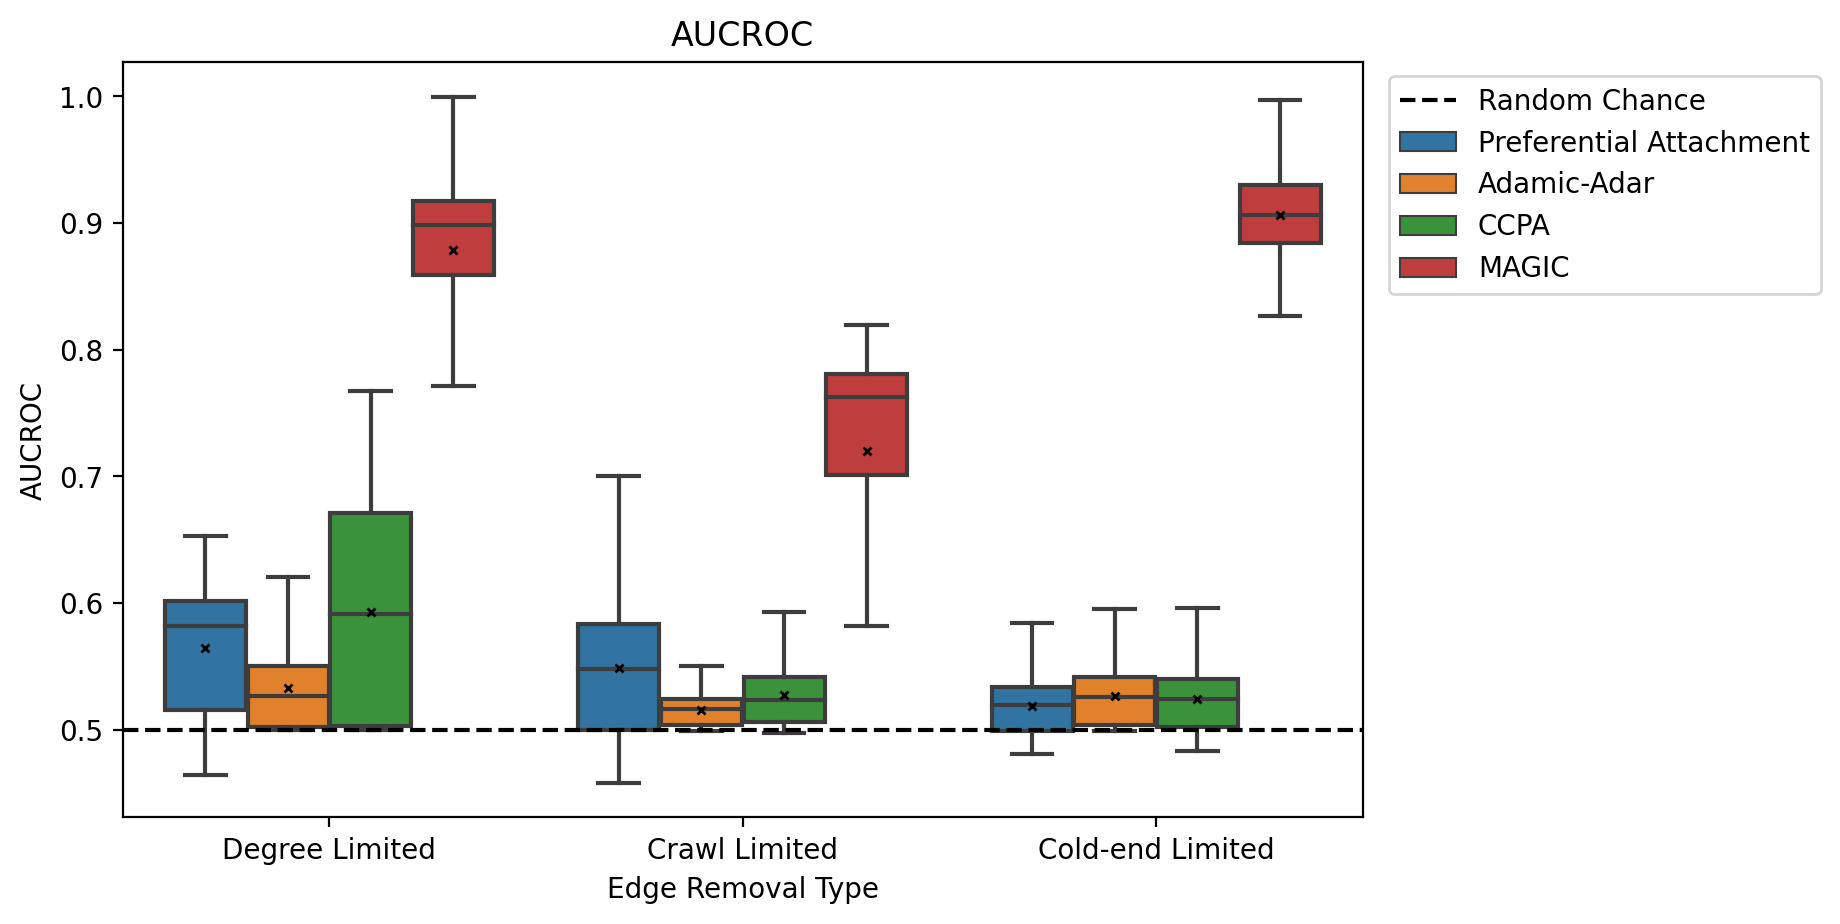

In [19]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 8, 5
fig = plt.figure()

sns.boxplot(data=results,
            x='missingType',
            hue='predictionAlgorithm',
            y='AUCROC',
            showfliers=False,
            showmeans=True,
            meanprops={"marker":"x",
                       "markerfacecolor":"r", 
                       "markeredgecolor":"k",
                       "markersize":3})

plt.axhline(y=0.5, ls='--', c='k', label='Random Chance')

plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.ylabel('AUCROC')
plt.xlabel('Edge Removal Type')
plt.title('AUCROC')

plt.show()

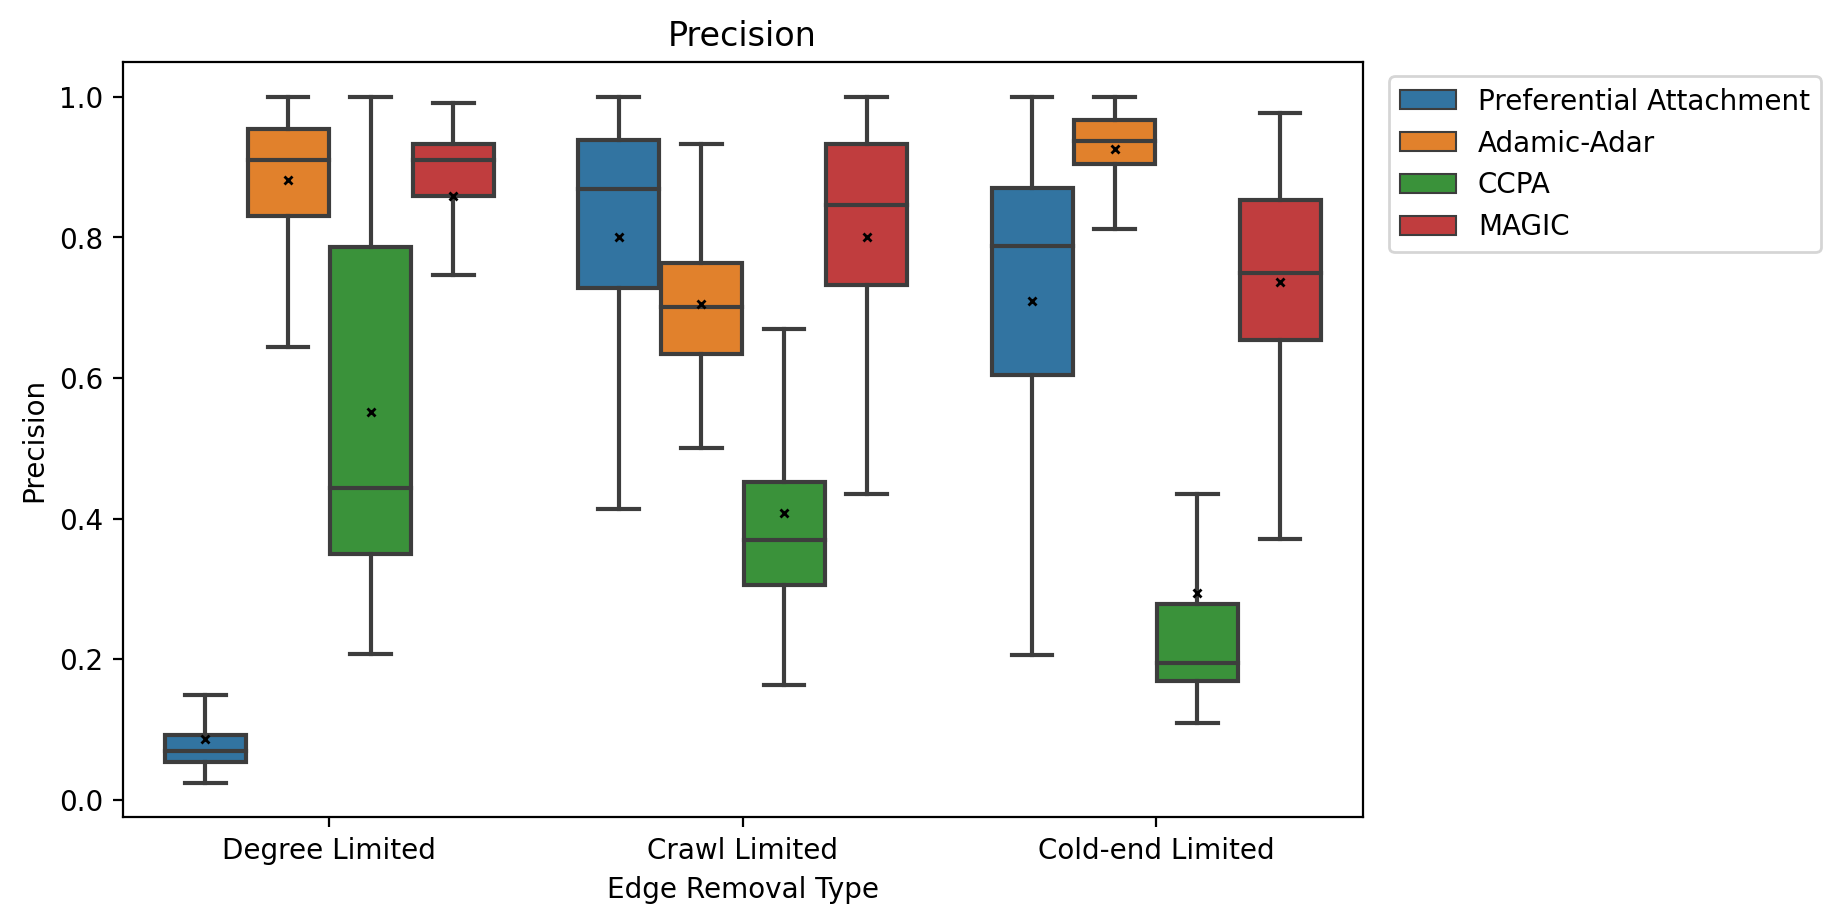

In [20]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 8, 5
fig = plt.figure()


sns.boxplot(data=results,
            x='missingType',
            hue='predictionAlgorithm',
            y='precision',
            showfliers=False,
            showmeans=True,
            meanprops={"marker":"x",
                       "markerfacecolor":"r", 
                       "markeredgecolor":"k",
                       "markersize":3})

plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.ylabel('Precision')
plt.xlabel('Edge Removal Type')
plt.title('Precision')

plt.show()

Text(0.5, 1.0, 'Number of Predicted Contacts')

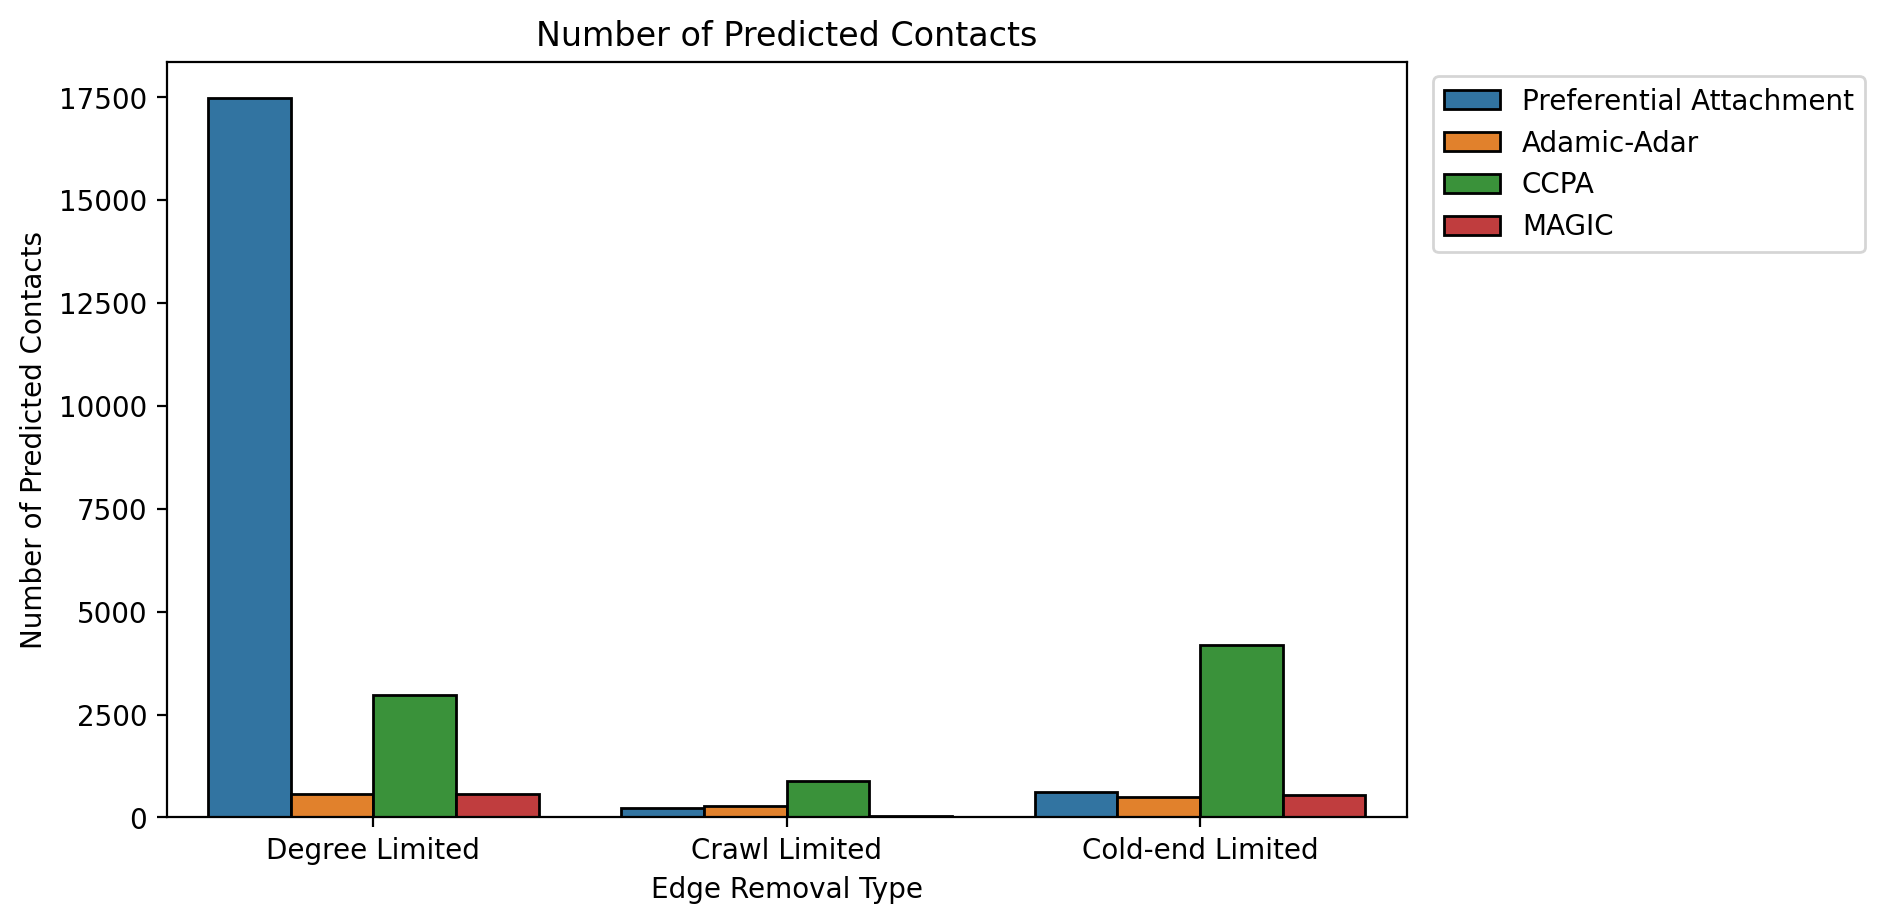

In [21]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 8, 5



sns.barplot(data=results,
            x='missingType',
            hue='predictionAlgorithm',
            y='nPred',
            ci=None,
            edgecolor='k')

plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.ylabel('Number of Predicted Contacts')
plt.xlabel('Edge Removal Type')
plt.title('Number of Predicted Contacts')

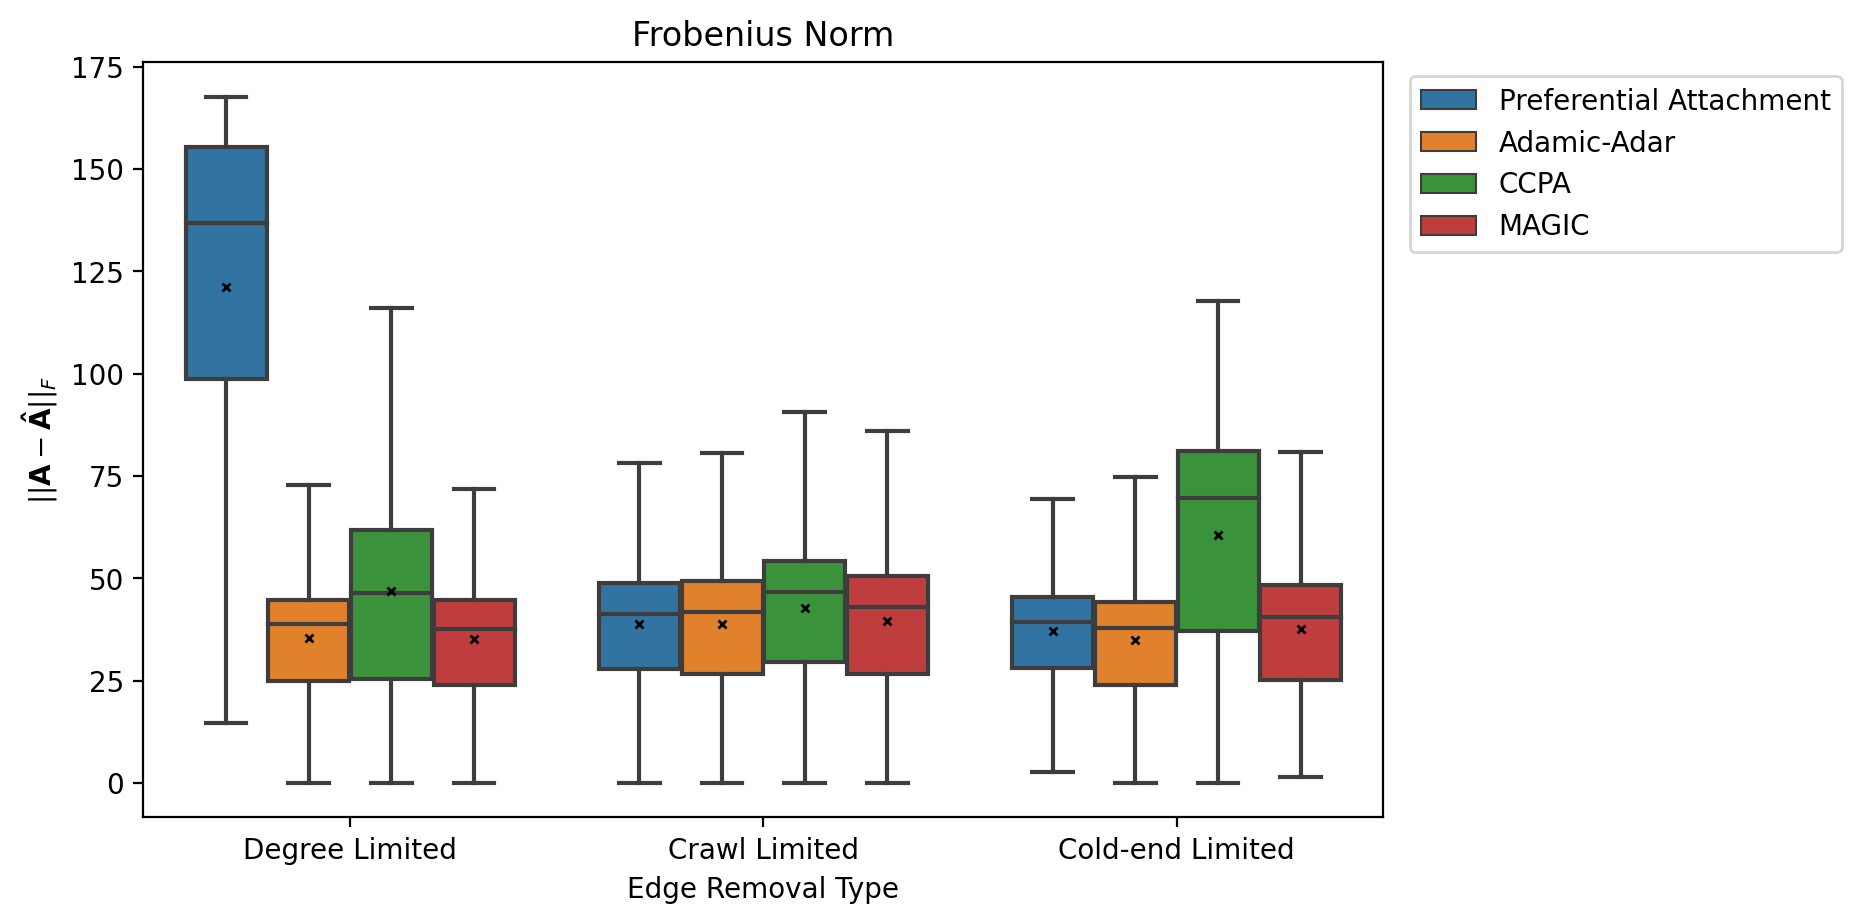

In [22]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 8, 5
fig = plt.figure()


sns.boxplot(data=results,
            x='missingType',
            hue='predictionAlgorithm',
            y='Fnorm',
            showfliers=False,
            showmeans=True,
            meanprops={"marker":"x",
                       "markerfacecolor":"r", 
                       "markeredgecolor":"k",
                       "markersize":3})


plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.ylabel('$||\mathbf{A} - \mathbf{\hat{A}}||_F$')
plt.xlabel('Edge Removal Type')
plt.title('Frobenius Norm')


plt.show()

In [23]:
# plt.rcParams['figure.dpi'] = 200
# plt.rcParams['figure.figsize'] = 8, 5
# fig = plt.figure()

# sns.boxplot(data=df,
#             x='missingType',
#             hue='predictionAlgorithm',
#             y='Jaccard_Index',
#             showfliers=False,
#             showmeans=True,
#             meanprops={"marker":"x",
#                        "markerfacecolor":"r", 
#                        "markeredgecolor":"k",
#                        "markersize":3})


# plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
# plt.ylabel('Jaccard Index')
# plt.xlabel('Edge Removal Type')
# plt.title('Jaccard Index')


# plt.show()

In [24]:
# break

In [25]:
grped = results.groupby(['missingType', 'predictionAlgorithm']).agg(
    JaccardMean=('Jaccard_Index', 'mean'),
    Jaccardstd=('Jaccard_Index', 'std'),
#     FnormMean=('Fnorm', 'mean'),
#     Fnormstd=('Fnorm', 'std'),
    AUCMean=('AUCROC', 'mean'),
    AUCstd=('AUCROC', 'std'),
).reset_index()

print(grped.round(3).to_latex(index=False))

\begin{tabular}{llrrrr}
\toprule
     missingType &     predictionAlgorithm &  JaccardMean &  Jaccardstd &  AUCMean &  AUCstd \\
\midrule
Cold-end Limited &             Adamic-Adar &        0.252 &       0.061 &    0.526 &   0.023 \\
Cold-end Limited &                    CCPA &        0.168 &       0.080 &    0.524 &   0.023 \\
Cold-end Limited &                   MAGIC &        0.211 &       0.063 &    0.906 &   0.043 \\
Cold-end Limited & Preferential Attachment &        0.226 &       0.072 &    0.519 &   0.022 \\
   Crawl Limited &             Adamic-Adar &        0.093 &       0.088 &    0.516 &   0.012 \\
   Crawl Limited &                    CCPA &        0.106 &       0.086 &    0.527 &   0.025 \\
   Crawl Limited &                   MAGIC &        0.028 &       0.072 &    0.720 &   0.095 \\
   Crawl Limited & Preferential Attachment &        0.086 &       0.086 &    0.549 &   0.048 \\
  Degree Limited &             Adamic-Adar &        0.262 &       0.061 &    0.533 &   0.037 \

In [26]:
results.to_csv('NaganoPredResults.csv', index=False)

In [27]:
grped = results.groupby(['missingType', 'predictionAlgorithm']).agg(
    mean=('Youdin', 'mean'),
    std=('Youdin', 'std'),
).reset_index()

print(grped.round(3).to_latex(index=False))

\begin{tabular}{llrr}
\toprule
     missingType &     predictionAlgorithm &  mean &   std \\
\midrule
Cold-end Limited &             Adamic-Adar & 0.382 & 0.646 \\
Cold-end Limited &                    CCPA & 0.898 & 0.445 \\
Cold-end Limited &                   MAGIC & 0.004 & 0.009 \\
Cold-end Limited & Preferential Attachment & 0.538 & 0.878 \\
   Crawl Limited &             Adamic-Adar & 0.507 & 0.392 \\
   Crawl Limited &                    CCPA & 0.572 & 0.358 \\
   Crawl Limited &                   MAGIC & 0.012 & 0.100 \\
   Crawl Limited & Preferential Attachment & 0.300 & 0.520 \\
  Degree Limited &             Adamic-Adar & 0.666 & 0.543 \\
  Degree Limited &                    CCPA & 0.610 & 0.554 \\
  Degree Limited &                   MAGIC & 0.003 & 0.009 \\
  Degree Limited & Preferential Attachment & 0.458 & 0.561 \\
\bottomrule
\end{tabular}



<ipython-input-60-d2a6b8bc1d11>:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fig.add_subplot(162)


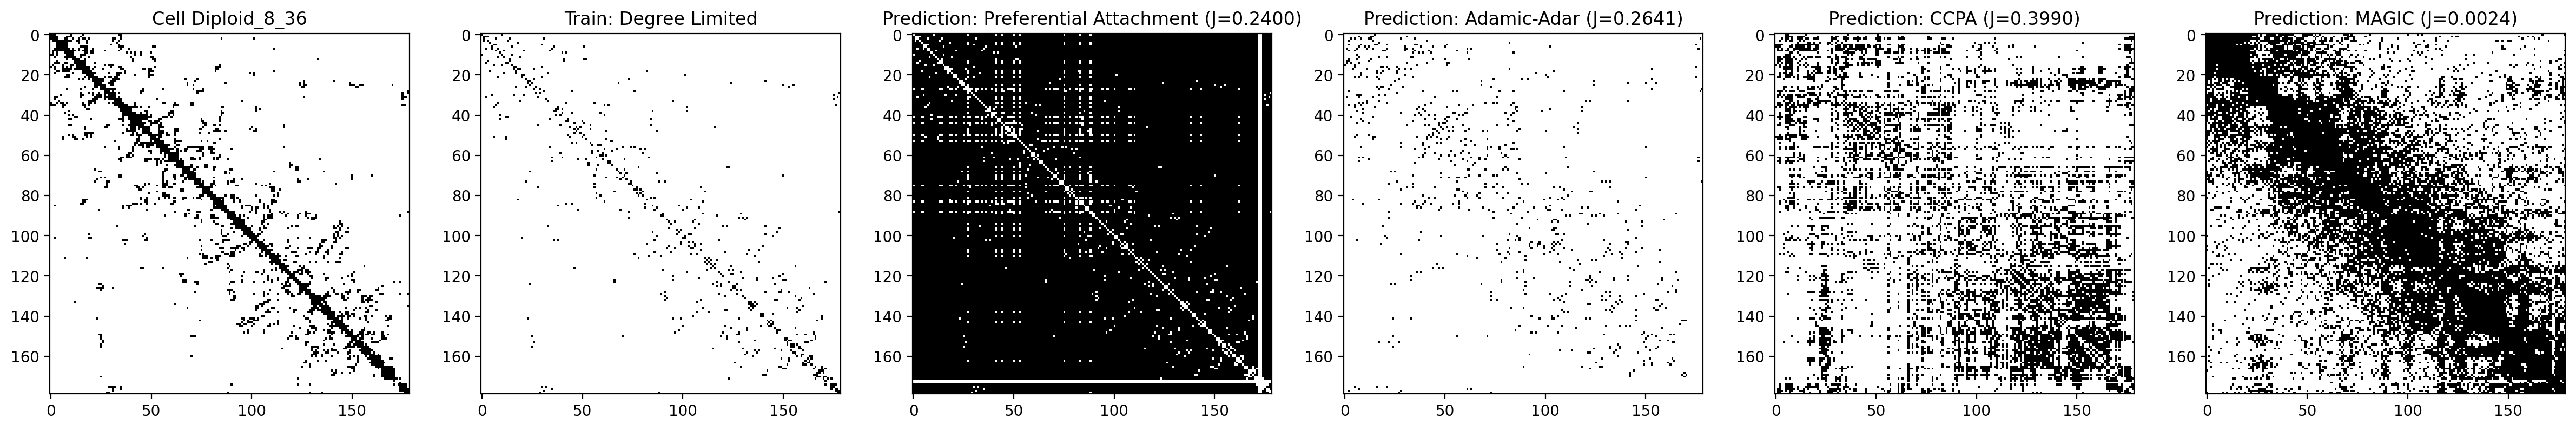

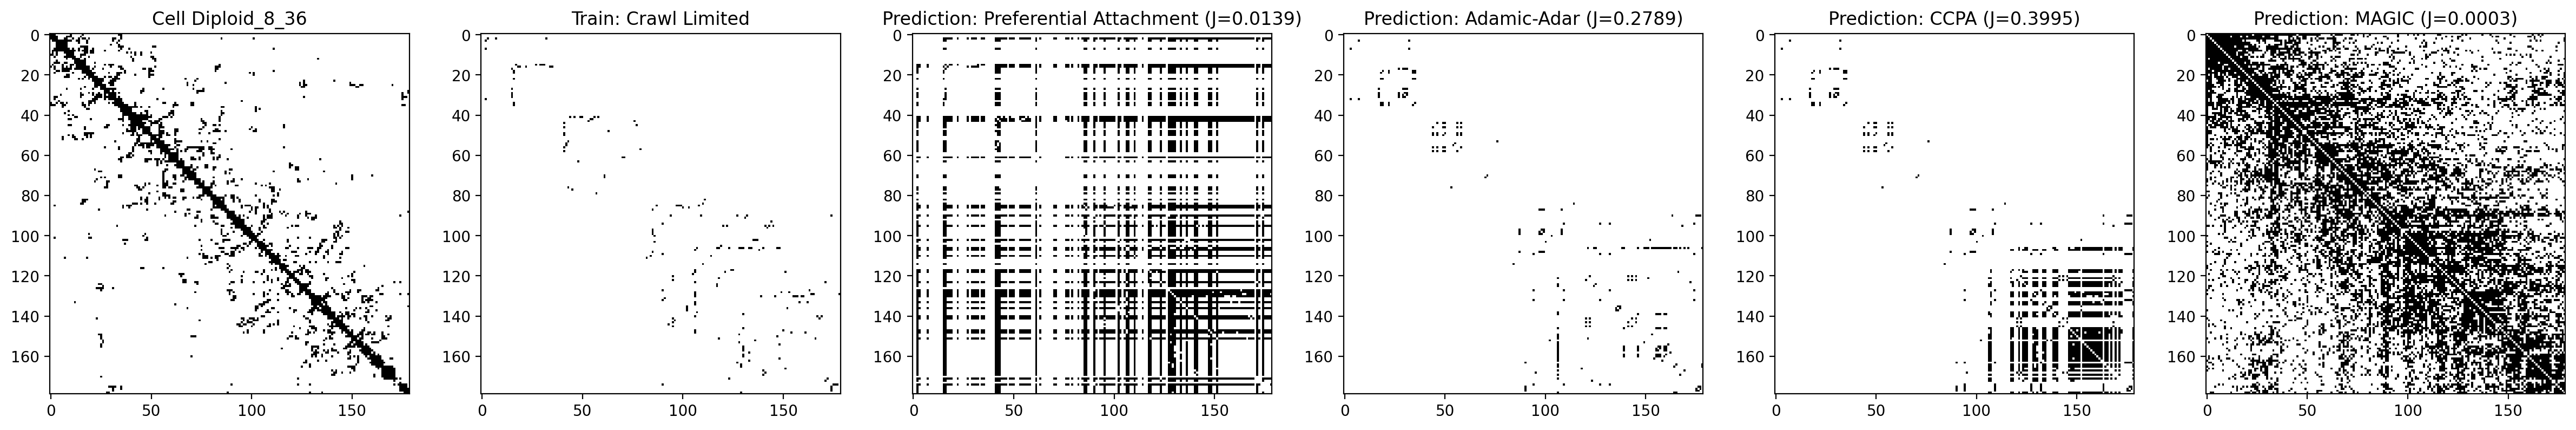

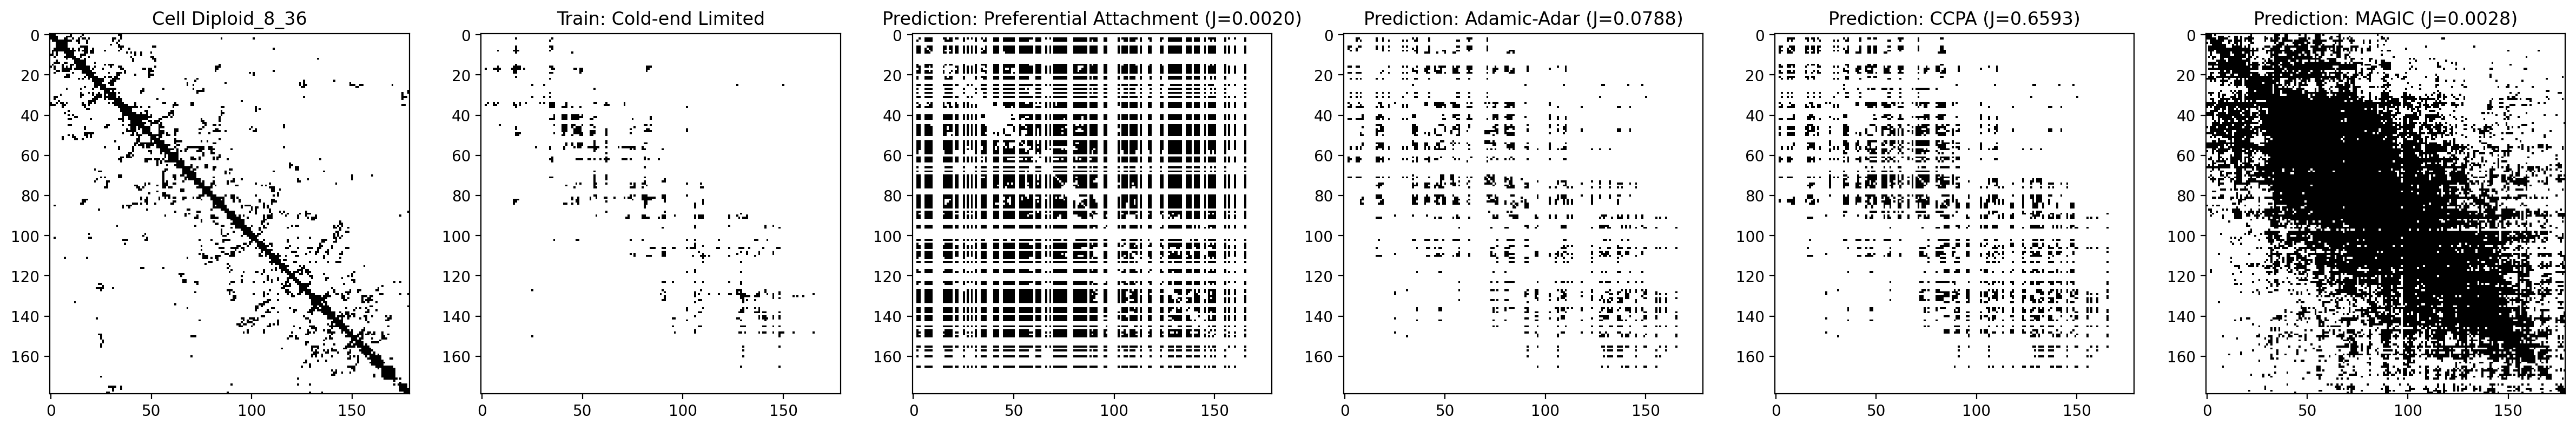

In [60]:
n = 1

scaleTau = 1.1

   
sampleKeys = np.random.choice(list(hic.keys()), n, replace=False)

for key in sampleKeys:
    for mTypeName in results['missingType'].unique():
        
        tmp = results[(results['cell'] == key) & (results['missingType'] == mTypeName)].reset_index(drop=True)
        
        plt.rcParams['figure.dpi'] = 200
        plt.rcParams['figure.figsize'] = 30, 30
        fig = plt.figure()
        
        fig.add_subplot(161)
        plt.imshow(hic[key], cmap='binary')
        plt.title(f"Cell {key}")
        
        for idx, row in tmp.iterrows():
        
            fig.add_subplot(162)
            plt.imshow(row['Atrain'], cmap='binary')
            plt.title(f'Train: {mTypeName}')

            fig.add_subplot(1, 6, 3+idx)
            J = row['Youdin']
            
#             print(f"{row['predictionAlgorithm']} {row['Ascores'].mean()=}")
            
            optimApred = np.where(row['Ascores'] >= (scaleTau*J), 1, 0)
            plt.imshow(optimApred, cmap='binary')
            plt.title(f'Prediction: {row["predictionAlgorithm"]} ({J=:.4f})')

In [29]:
n = 1
tau = 0.01

for mTypeName, data in res.items():
    
    sampleKeys = np.random.choice(data['cellKeys'], n, replace=False)
    
    for key in sampleKeys:
        idx = data['cellKeys'].index(key)
        
        Atrue = data['True'][idx, :]
        Atrain = data['Train'][idx, :]
        Apred = data['Pred'][idx, :]
        
        dim = int(np.sqrt(Atrue.shape[0]))

        Atrue = Atrue.reshape((dim, dim))
        Atrain = Atrain.reshape((dim, dim))
        Apred = Apred.reshape((dim, dim))
    
        AUC = roc_auc_score(np.triu(Atrue).ravel(), 
                np.triu(Apred).ravel())
        
        Apred = np.where(Apred > tau, 1, 0)

        print(f"{mTypeName=} {AUC=:.4f}")

        plt.rcParams['figure.dpi'] = 200
        plt.rcParams['figure.figsize'] = 15, 15
        fig = plt.figure()

        fig.add_subplot(131)
        plt.imshow(Atrue, cmap='binary')
        plt.title(f'Ground Truth Data')

        fig.add_subplot(132)
        plt.imshow(Atrain, cmap='binary')
        plt.title(f'Training Data: {mTypeName}')

        fig.add_subplot(133)
        plt.imshow(Apred, cmap='binary')
        plt.title('Predicted Data (Magic)')

        plt.suptitle(f"{key}", y=.65)
            


KeyError: 'Pred'

In [ ]:
# n = 1

# for idx, row in df.sample(n).iterrows():
#     key = row['cell']
#     missType = row['missingType']
    
#     Atrue = hic[key]
#     Atrain = missingType[missType][key]
#     Apred = row['predMatrix']
    
#     plt.rcParams['figure.dpi'] = 200
#     plt.rcParams['figure.figsize'] = 15, 15
#     fig = plt.figure()

#     fig.add_subplot(131)
#     plt.imshow(Atrue, cmap='binary')
#     plt.title(f'Ground Truth Data')

#     fig.add_subplot(132)
#     plt.imshow(Atrain, cmap='binary')
#     plt.title(f'Training Data: {missType}')
    
#     fig.add_subplot(133)
#     plt.imshow(Apred, cmap='binary')
#     plt.title('Predicted Data')
    
#     plt.suptitle(f"{row['predictionAlgorithm']} --> {key}", y=.65)

#     plt.show()

In [ ]:
n = 100

sampleKeys = np.random.choice(list(hic.keys()), n, replace=False)

res = {}

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    for mTypeName, Adict in missingType.items():

        multiCellTrain = []
        multiCellTrue = []
        keys = []


        for key in sampleKeys:
            Atrain = np.asarray(Adict[key])
            Atrue = np.asarray(hic[key])

            multiCellTrain.append(Atrain.flatten())
            multiCellTrue.append(Atrue.flatten())
            
            keys.append(key)

        multiCellTrain = np.asarray(multiCellTrain)
        multiCellTrue = np.asarray(multiCellTrue)

        print(f"{multiCellTrain.shape=}")
        print(f"{multiCellTrue.shape=}")

        magic_operator = magic.MAGIC(verbose=False,
                                     knn=7,
                                     t=2, 
                                     n_pca=4)


        multiCellPred = magic_operator.fit_transform(multiCellTrain)
        print(f"{multiCellPred.shape=}")
        
        res[mTypeName] = {
            'True' : multiCellTrue,
            'Train' : multiCellTrain,
            'Pred' : multiCellPred,
            'cellKeys' : keys
        }

res.keys()

In [ ]:
n = 50
tau = 0.01

newRows = []

for mTypeName, data in res.items():
    
    sampleKeys = np.random.choice(data['cellKeys'], n, replace=False)
    
    for key in sampleKeys:
        idx = data['cellKeys'].index(key)
        
        Atrue = data['True'][idx, :]
        Atrain = data['Train'][idx, :]
        Apred = data['Pred'][idx, :]
        
        dim = int(np.sqrt(Atrue.shape[0]))

        Atrue = Atrue.reshape((dim, dim))
        Atrain = Atrain.reshape((dim, dim))
        Apred = Apred.reshape((dim, dim))
        
        
         # AUC computed with scores
        try:
            AUC = roc_auc_score(np.triu(Atrue).ravel(), 
                                np.triu(Apred).ravel())
        except ValueError:
            AUC = 0.5
            
        Apred = np.where(Apred > tau, 1, 0)

        _, mannU = imputation.mannUManual(np.triu(Atrue).ravel(), 
                                          np.triu(Apred).ravel())

        Jaccard = jaccard_score(np.triu(Atrue).ravel(), 
                                np.triu(Apred).ravel(), 
                                zero_division='ignore')

        Fnorm = np.linalg.norm(Atrue - Apred)

        nTrue = np.sum(np.sum(Atrue))
        nPred = np.sum(np.sum(Apred))

        tn, fp, fn, tp = confusion_matrix(np.triu(Atrue).ravel(), np.triu(Apred).ravel(), labels=[0, 1]).ravel()

        row = {
            'cell' : key,
            'missingType' : mTypeName,
            'Jaccard_Index' : Jaccard,
            'Fnorm' : Fnorm,
            'AUCROC' : AUC,
            'MannUAUC' : mannU,
            'nTrue' : nTrue,
            'nPred' : nPred,
            'TrueNegative' : tn,
            'TruePositive' : tp,
            'FalseNegative' : fn,
            'FalsePositive' : fp,
            'sensitivity' : tp / (tp + fn),
            'specificity' : tn / (tn + fp),
            'precision' : tp / (tp + fp),
            'falseDiscovery' : fp / (fp + tp),
        }
        
        newRows.append(row)

dfMagic = pd.DataFrame(newRows)
print(f"{dfMagic.shape=}")
dfMagic.head()

In [ ]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 8, 5
fig = plt.figure()


sns.boxplot(data=dfMagic,
            x='missingType',
            y='AUCROC',
            showfliers=False,
            showmeans=True,
            meanprops={"marker":"x",
                       "markerfacecolor":"r", 
                       "markeredgecolor":"k",
                       "markersize":3})


# plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.ylabel('AUCROC')
plt.xlabel('Edge Removal Type')
plt.title('AUCROC MAGIC')


plt.show()

In [ ]:
n = 1
tau = 0.01

for mTypeName, data in res.items():
    
    sampleKeys = np.random.choice(data['cellKeys'], n, replace=False)
    
    for key in sampleKeys:
        idx = data['cellKeys'].index(key)
        
        Atrue = data['True'][idx, :]
        Atrain = data['Train'][idx, :]
        Apred = data['Pred'][idx, :]
        
        dim = int(np.sqrt(Atrue.shape[0]))

        Atrue = Atrue.reshape((dim, dim))
        Atrain = Atrain.reshape((dim, dim))
        Apred = Apred.reshape((dim, dim))
    
        AUC = roc_auc_score(np.triu(Atrue).ravel(), 
                np.triu(Apred).ravel())
        
        Apred = np.where(Apred > tau, 1, 0)

        print(f"{mTypeName=} {AUC=:.4f}")

        plt.rcParams['figure.dpi'] = 200
        plt.rcParams['figure.figsize'] = 15, 15
        fig = plt.figure()

        fig.add_subplot(131)
        plt.imshow(Atrue, cmap='binary')
        plt.title(f'Ground Truth Data')

        fig.add_subplot(132)
        plt.imshow(Atrain, cmap='binary')
        plt.title(f'Training Data: {mTypeName}')

        fig.add_subplot(133)
        plt.imshow(Apred, cmap='binary')
        plt.title('Predicted Data (Magic)')

        plt.suptitle(f"{key}", y=.65)
            
